Space to scratch out the mechanism for running all the processes I want to run on individual ROIs of classified cone mosaic data.

Inputs

In [23]:
# Paths
# -----
# load and save folder. all coordinate and image data must be in the load folder ()
# if there is already analyses for a mosaic that you want to add analyses to, it must 
# be located in the save file the same name as the coordinate file but with the save file-type
data_path = 'C:\\Users\\schle\Documents\\GitHub\\Incubator-2022-Geometry-of-Color\\CSV data all OCT locs Jan 2022\\'
save_path = 'C:\\Users\\schle\Documents\\Incubator Data\\'

# settings that define the files that will be searched for in the load folder above.
# processes indicated below will be run on all such files found.
# Single_mosaic_processes will search for cone coordinate .csvs corresponding to all combinations of these parameters.
# Single_mosaic_processes  will search for come image .pngs corresponding to all combinations of subject, angle, and eccentricity.
# these images correspond universally to the conetype_ids input.  
subject = ['AO001R', 'AO008R']
angle = ['temporal', 'nasal', 'superior', 'inferior']
eccentricity = ['1.5', '4', '10']
conetype = ['all','L','M','S','unclassed']
conetype_color = ['y','r','g','b','w']
coord_unit = 'pixels' # units of the coordinate data loaded in - any string you want

# Run settings
# ------------
# select single-mosaic processes to run

# options: 'basic stats', 'intracone_dists', 'monteCarlo_Uniform', 'monteCarlo_coneLocked
proc_to_run = {'intracone_dist', 'monteCarlo_uniform', 'monteCarlo_coneLocked'}

# indicate whether all processes requested will be run on all mosaics found fitting the inputs above,
# or processes will only be run for a file if that process' outputs are not present in an identified save file
data_to_run = 'all' # 'all', absent_only

# Process-specific Settings
# -------------------------
# intracone distance settings
dist_area_norm = False # bool

# monteCarlo_uniform and monteCarlo-coneLocked settings
num_mc = 100 # number of monte carlo mosaics to generate

Import packages, some additional hardcoded variables (move these to a settings file eventually), helpful type changes, and variable grouping

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import os
import h5py
import importlib
import glob
import yaml
import sys

import mosaic_topog.utilities as util
import mosaic_topog.flsyst as flsyst
import mosaic_topog.show as show
import mosaic_topog.calc as calc
import mosaic_topog.singleMosaicProcesses as smp

subject = np.asarray(subject)
angle = np.asarray(angle)
eccentricity = np.asarray(eccentricity)

single_mosaic_savefl_config = 'savefl_config.yml'

coord_fltype = '.csv'
img_fltype = '.png'
filetypes = [coord_fltype, img_fltype]

conetype_sizes = [10, 10, 10, 30]


bin_width = 10

categories = [subject, angle, eccentricity]


# set up for "user_param," a dictionary that is passed to the process manager that
# stores all the variables determined from the user's inputs
user_param_keys = [
                   'subject',
                   'angle',
                   'eccentricity',
                   'conetype',
                   'coord_unit',
                   'bin_width',
                   'dist_area_norm',
                   'conetype_color',
                   ]
waitlist = [
            'mosaic',
            'coord_fl_name',
            'coord_index',
            'img_fl_name',
            'img_index',
            'save_name',
            'processes'
            ] # make sure that parameters in this list are set to user_parm downstream

user_param = dict.fromkeys(user_param_keys)
# most of these parameters have been set directly by the user, 
# a few need to be interpreted from the filesystem, however. 
for p in user_param:
    if not p in waitlist:
        user_param[p] = locals()[p]

Function scratch space

Get all possible coordinate filenames based on the user inputs and find the ones that exist in the folder. 

In [25]:


# fl_names is the output variable we care about for now -
#     it's a list of all files found for combinations of the input parameters.
# mosaics is a list of all the unique combinations of mosaics
# index is a dictionary for indexing through the list flnames according to:
#     inputs to single_mosaic_processes - subject, angle, eccentricity, conetype_ids 
#     determined by single_mosaic_processes - 
mosaic, coord_fl_name, coord_index = flsyst.getFilesByDataGroup(data_path, user_param, '.csv')
img_mosaic, img_fl_name, img_index = flsyst.getFilesByDataGroup(data_path, user_param, '.png')

# Make list of expected save-file names for this data
save_name = flsyst.saveNameFromLoadPath(coord_fl_name,save_path)


found 110 files

found 22 files



Load in the configuration file that determines the Single_mosaic_processes save file structure

In [26]:
sav_cfg = flsyst.readYaml(single_mosaic_savefl_config)

If we want to run all the data, start processes.  Otherwise, read from the save folder to determine which data needs to be run through which processes -- then start processes. 

In [27]:
if data_to_run == 'all':
    processes = {}
    for proc in proc_to_run:
        processes[proc] = np.arange(0,len(coord_fl_name)).tolist()
elif data_to_run == 'absent_only':
    processes = flsyst.getProcessesToRun(fl_name, save_name, save_path, proc_to_run, sav_cfg)


In [28]:
for p in waitlist:
    user_param[p] = vars()[p]
    
for p in user_param:
    print(p)
    print(user_param[p])
    print('')

subject
['AO001R' 'AO008R']

angle
['temporal' 'nasal' 'superior' 'inferior']

eccentricity
['1.5' '4' '10']

conetype
['all', 'L', 'M', 'S', 'unclassed']

coord_unit
pixels

bin_width
10

dist_area_norm
False

conetype_color
['y', 'r', 'g', 'b', 'w']

mosaic
['AO001R_temporal_1.5', 'AO001R_temporal_10', 'AO001R_nasal_1.5', 'AO001R_nasal_4', 'AO001R_nasal_10', 'AO001R_superior_1.5', 'AO001R_superior_4', 'AO001R_superior_10', 'AO001R_inferior_1.5', 'AO001R_inferior_4', 'AO001R_inferior_10', 'AO008R_temporal_1.5', 'AO008R_temporal_10', 'AO008R_nasal_1.5', 'AO008R_nasal_4', 'AO008R_nasal_10', 'AO008R_superior_1.5', 'AO008R_superior_4', 'AO008R_superior_10', 'AO008R_inferior_1.5', 'AO008R_inferior_4', 'AO008R_inferior_10']

coord_fl_name
['C:\\Users\\schle\\Documents\\GitHub\\Incubator-2022-Geometry-of-Color\\CSV data all OCT locs Jan 2022\\AO001R_temporal_1.5_all.csv', 'C:\\Users\\schle\\Documents\\GitHub\\Incubator-2022-Geometry-of-Color\\CSV data all OCT locs Jan 2022\\AO001R_temporal_1

In [29]:
importlib.reload(flsyst)
importlib.reload(smp)
importlib.reload(calc)
importlib.reload(show)

<module 'mosaic_topog.show' from 'c:\\users\\schle\\documents\\github\\incubator-2022-geometry-of-color\\mosaic_topog\\mosaic_topog\\show.py'>

In [30]:
smp.runSingleMosaicProcess(user_param, sav_cfg)

c:\users\schle\documents\github\incubator-2022-geometry-of-color\mosaic_topog\mosaic_topog\singleMosaicProcesses.py:107: UserWarning: loadtxt: Empty input file: "C:\Users\schle\Documents\GitHub\Incubator-2022-Geometry-of-Color\CSV data all OCT locs Jan 2022\AO001R_temporal_1.5_unclassed.csv"
  if var == 'cone_img':


AO001R_temporal_1.5_unclassed contains < 2 cones, skipping... 
AO001R_temporal_10_unclassed contains < 2 cones, skipping... 


c:\users\schle\documents\github\incubator-2022-geometry-of-color\mosaic_topog\mosaic_topog\show.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  else:


AO008R_temporal_10_unclassed contains < 2 cones, skipping... 


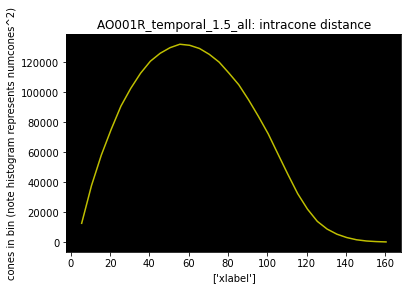

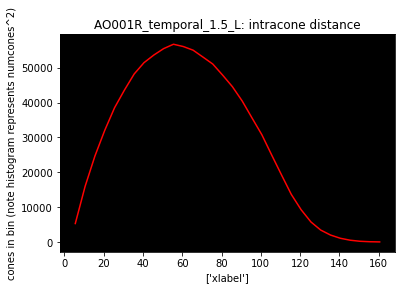

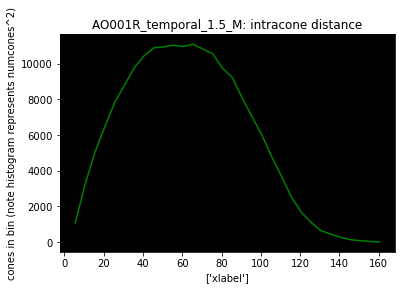

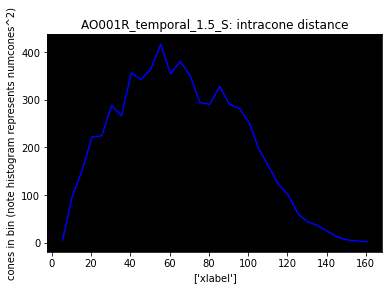

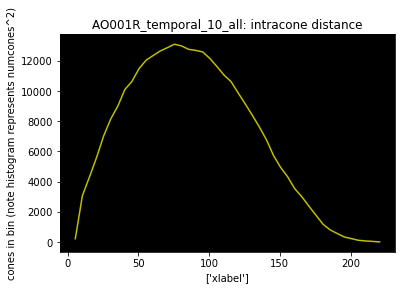

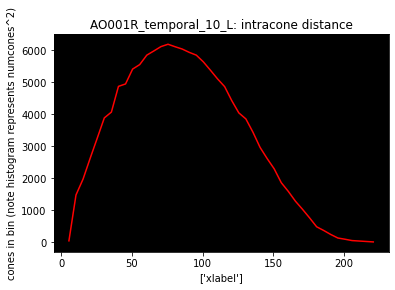

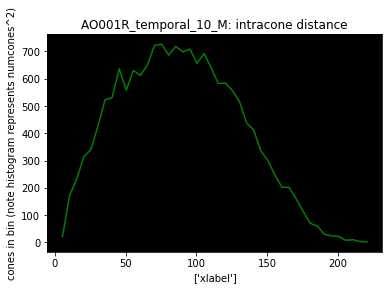

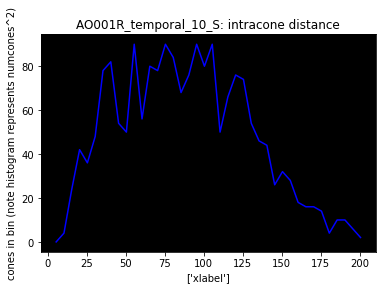

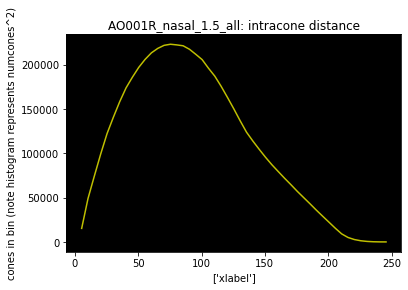

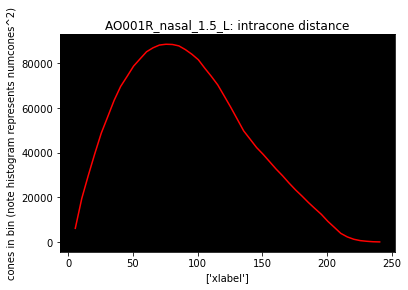

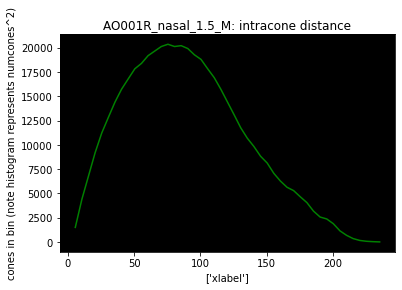

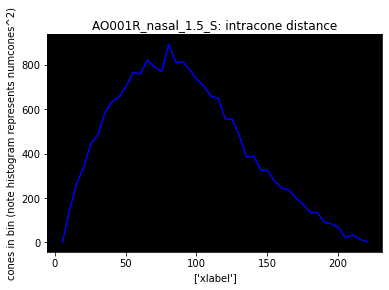

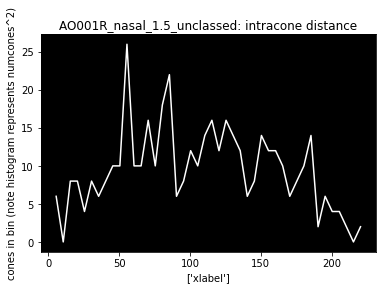

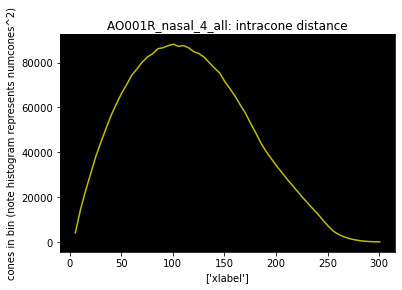

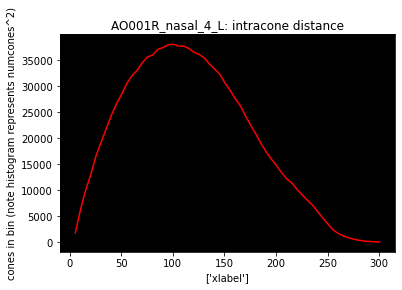

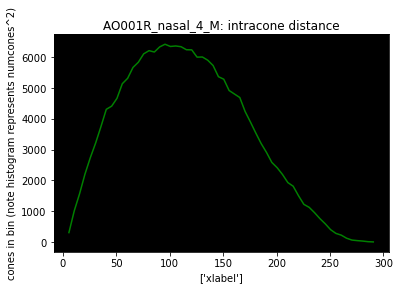

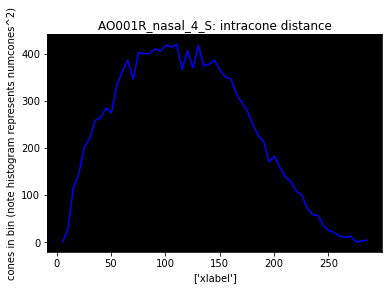

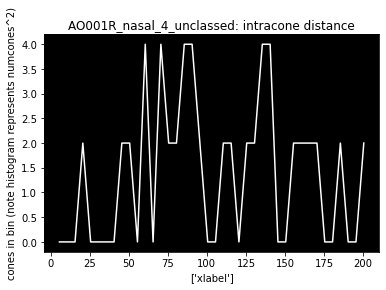

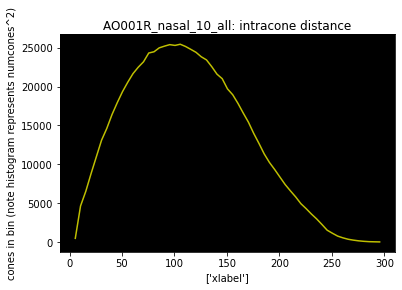

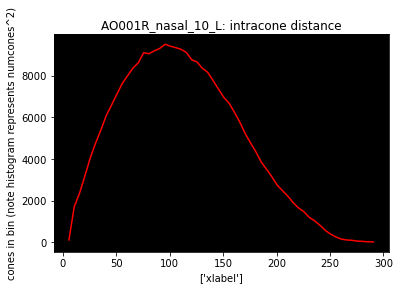

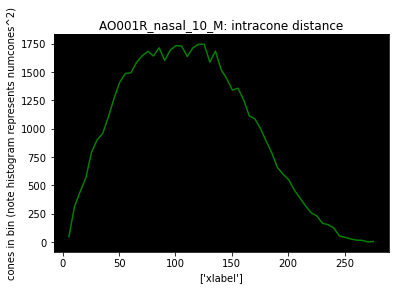

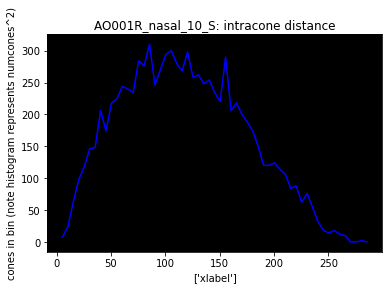

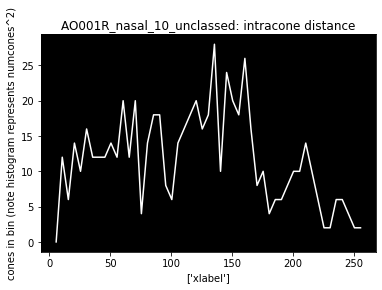

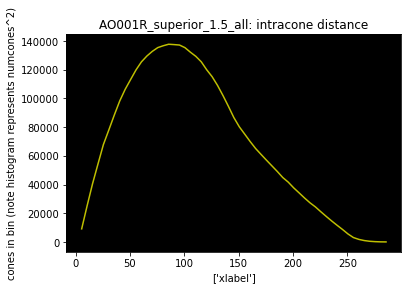

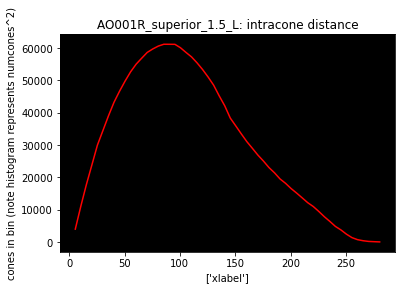

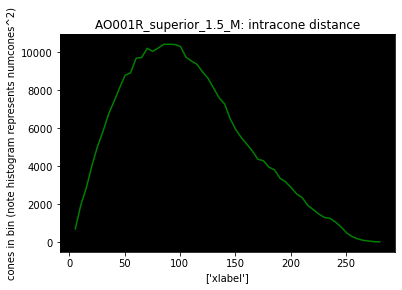

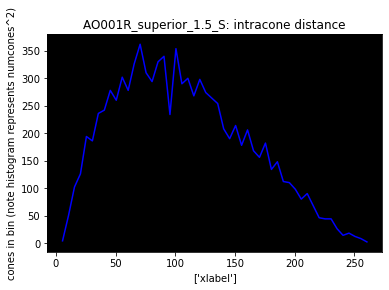

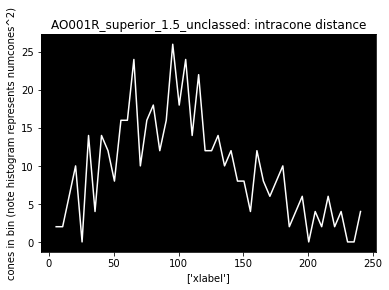

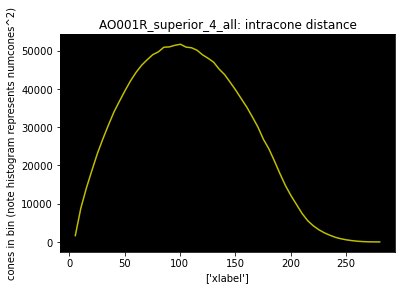

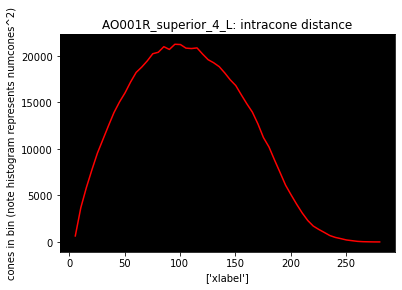

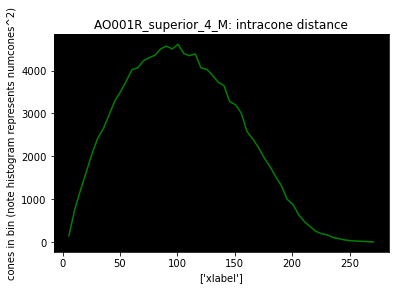

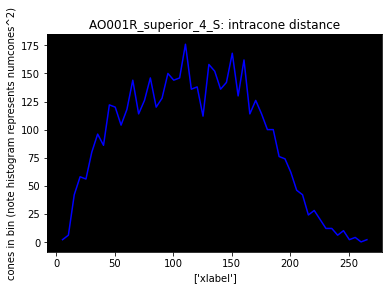

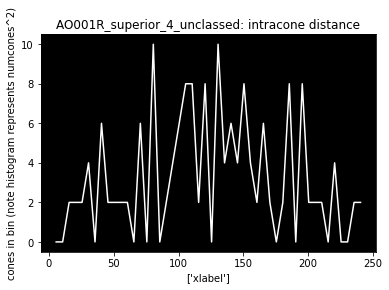

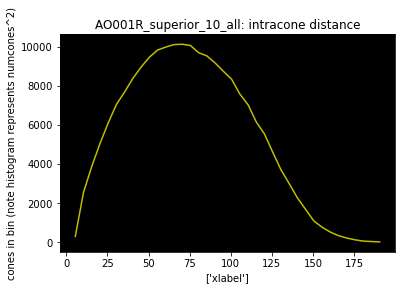

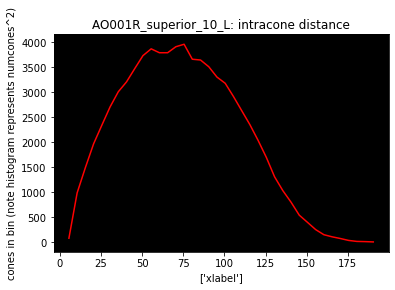

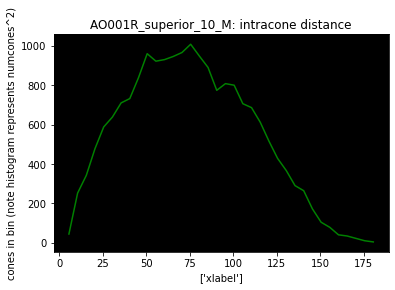

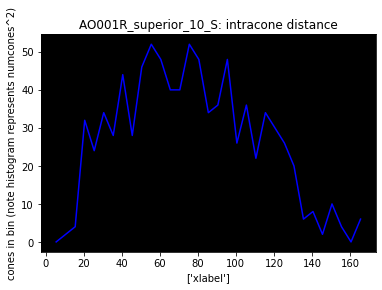

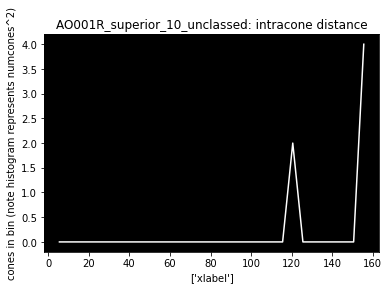

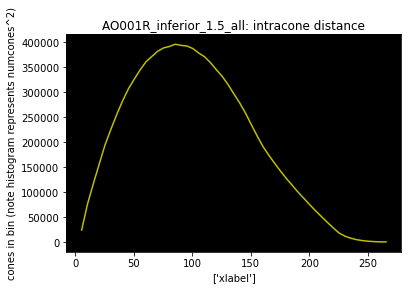

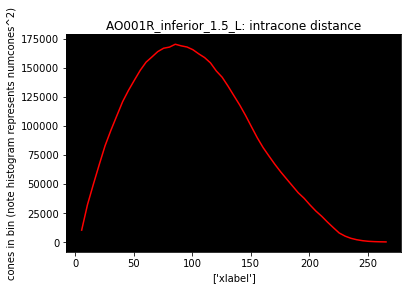

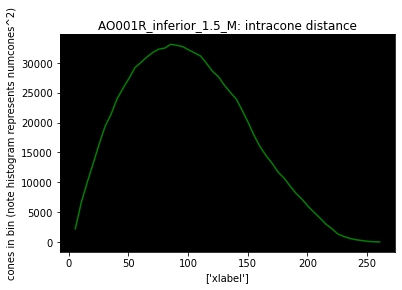

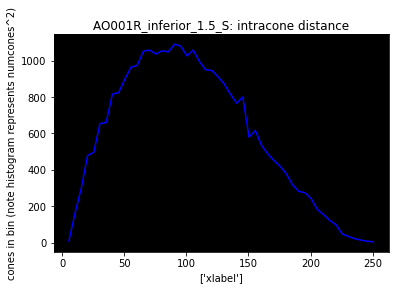

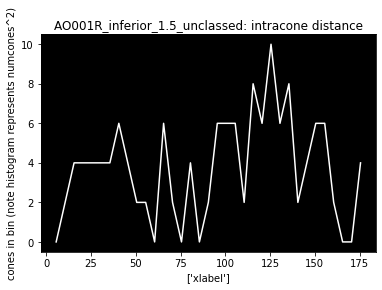

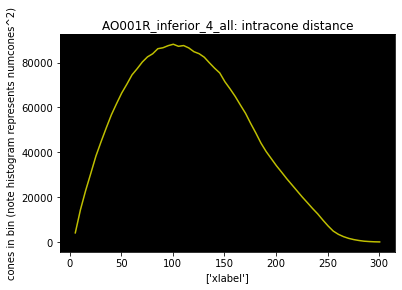

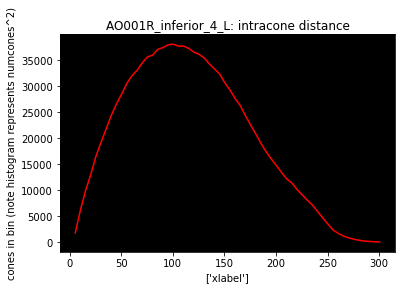

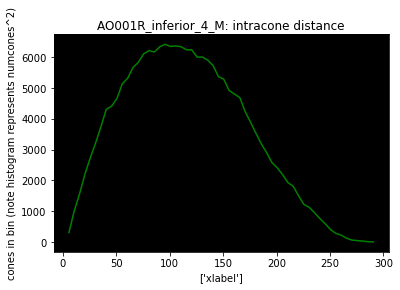

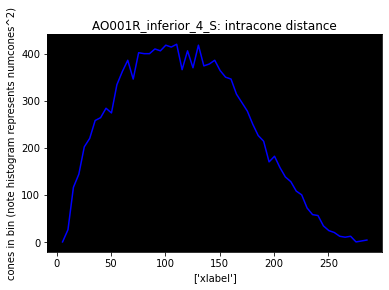

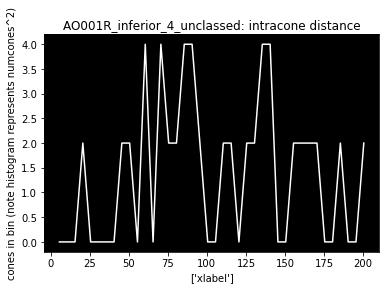

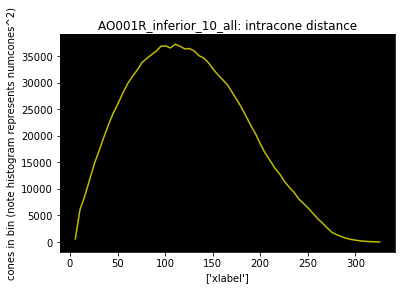

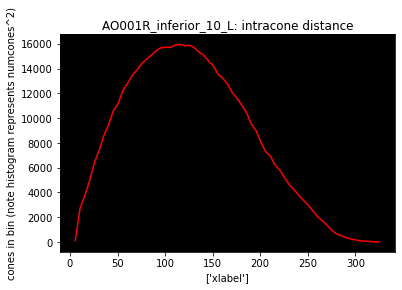

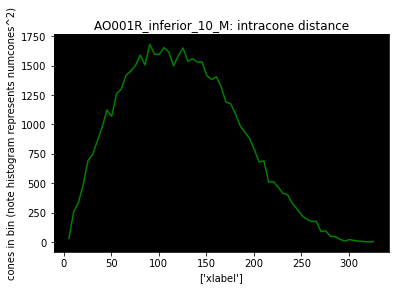

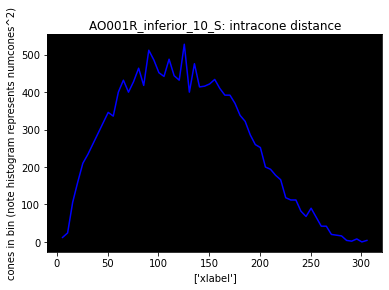

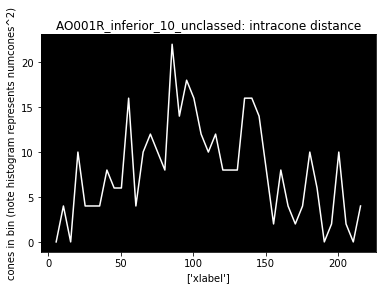

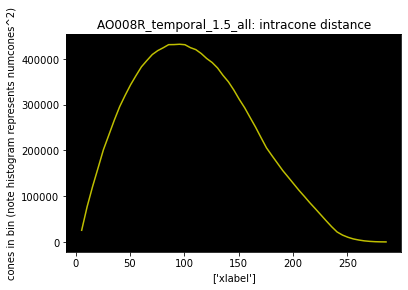

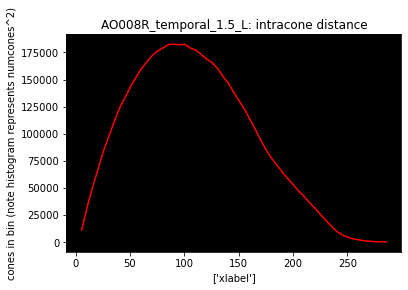

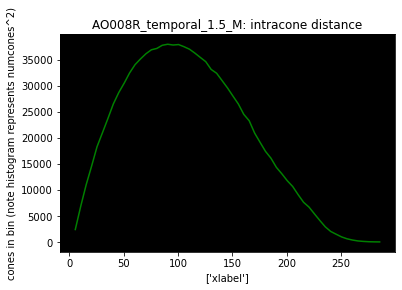

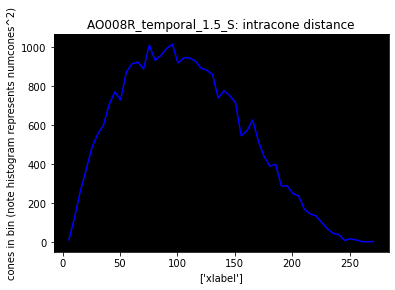

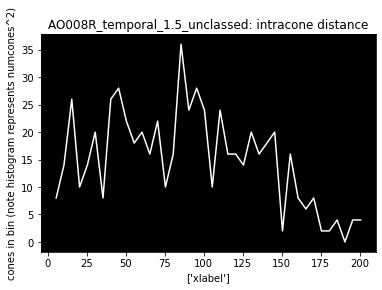

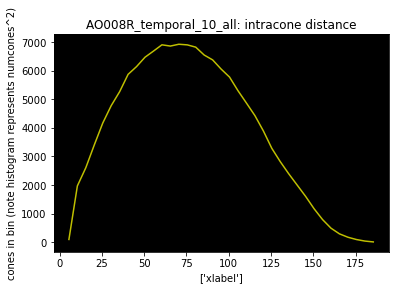

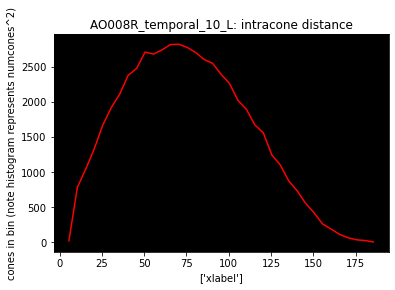

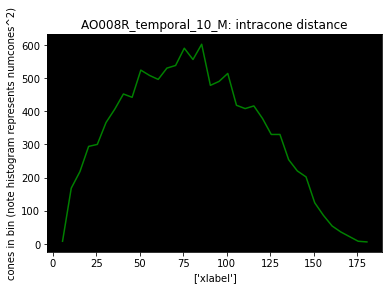

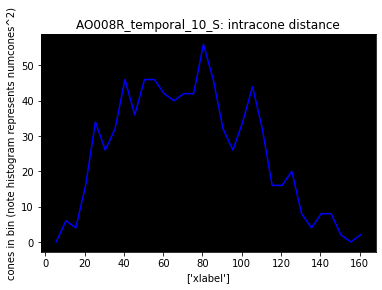

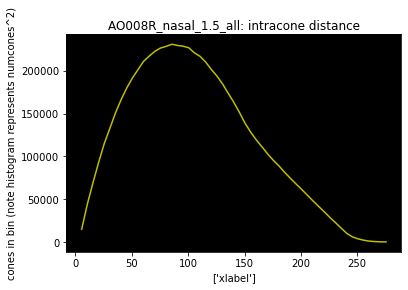

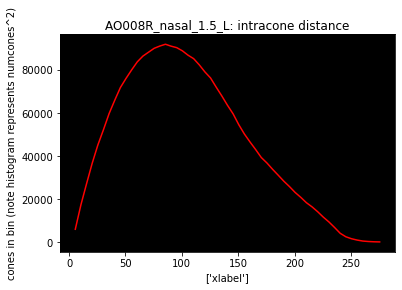

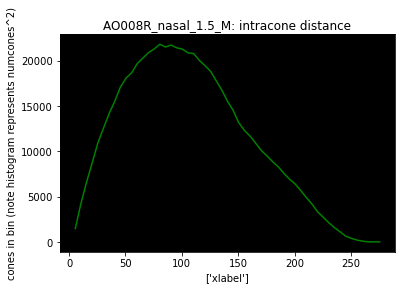

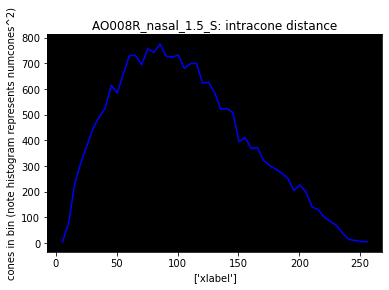

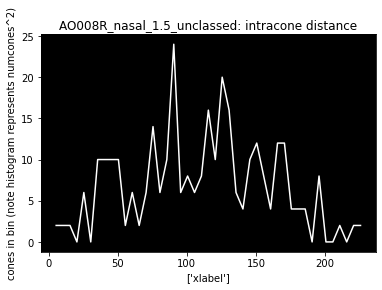

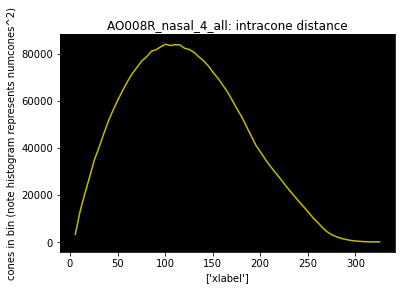

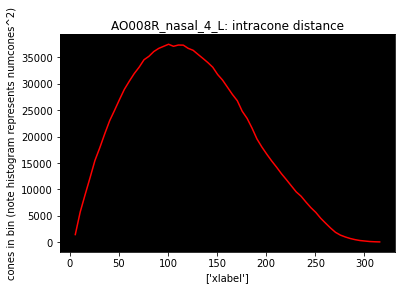

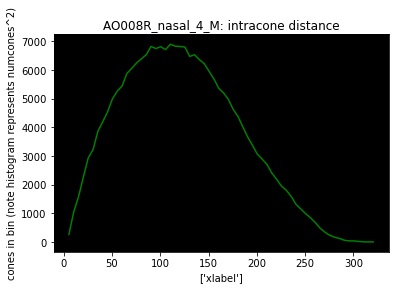

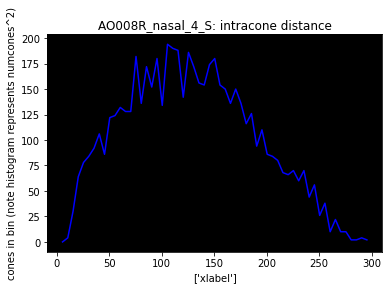

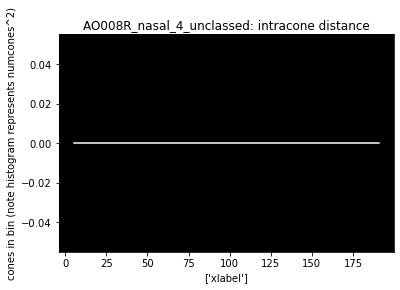

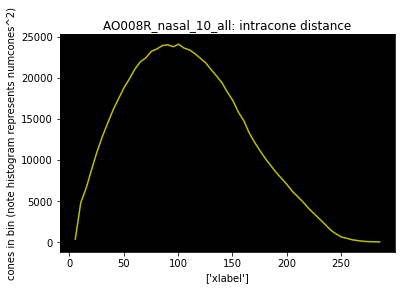

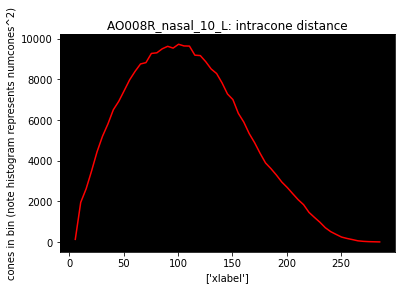

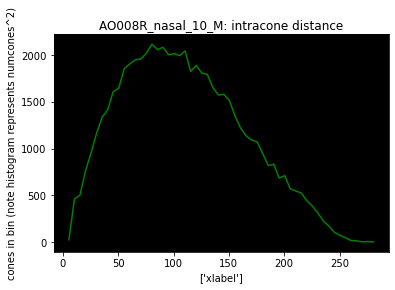

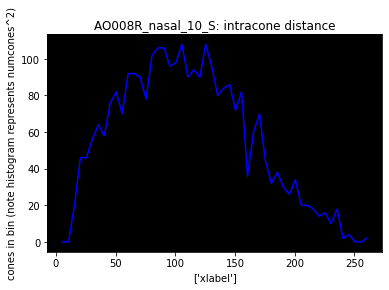

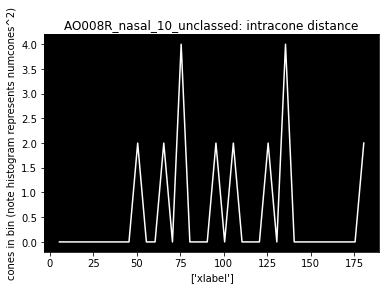

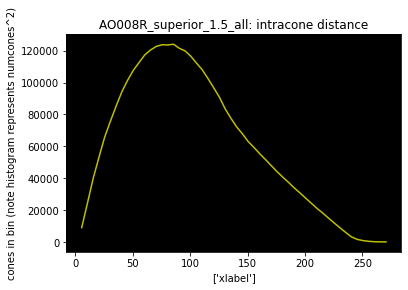

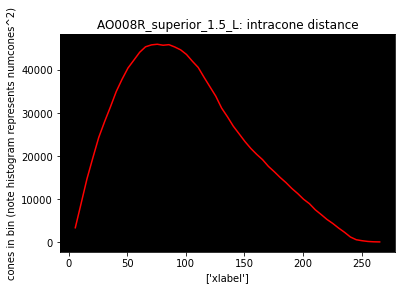

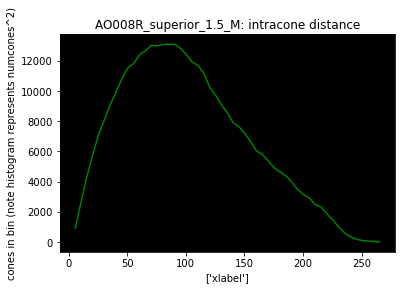

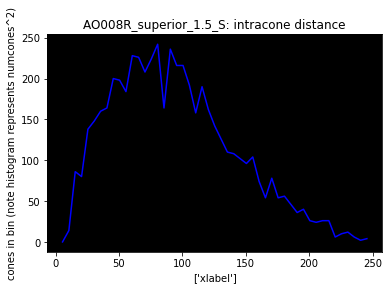

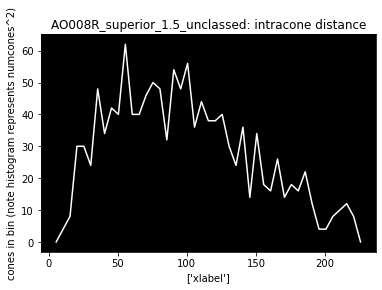

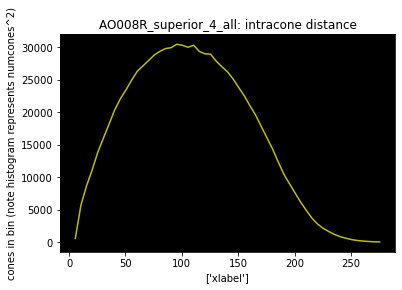

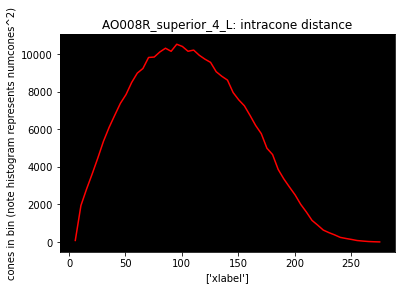

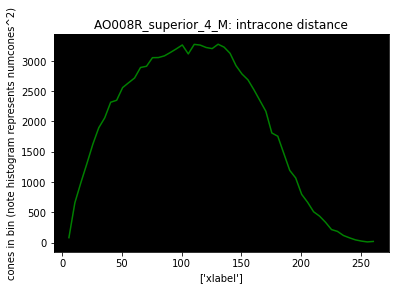

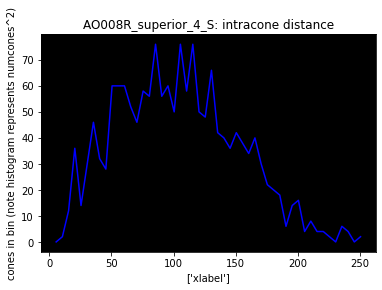

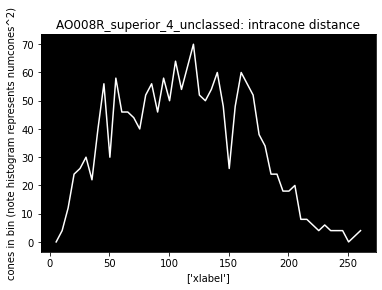

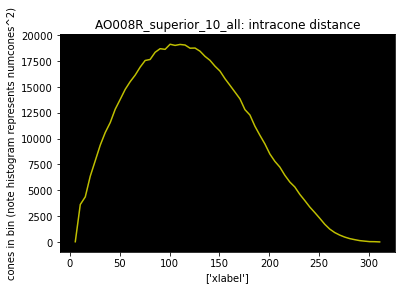

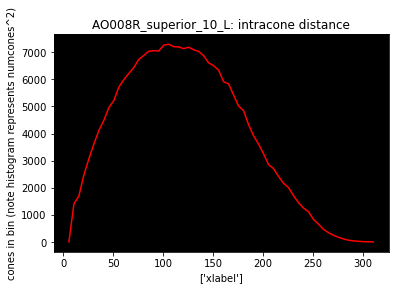

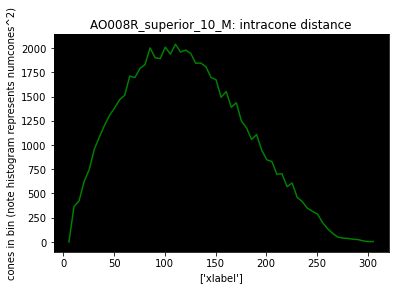

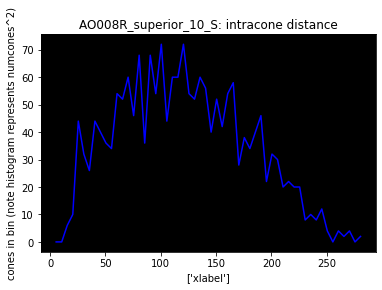

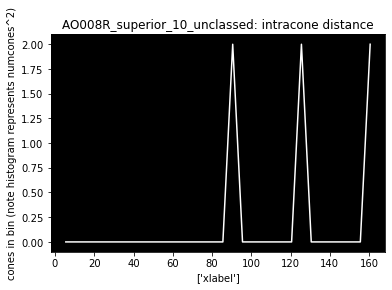

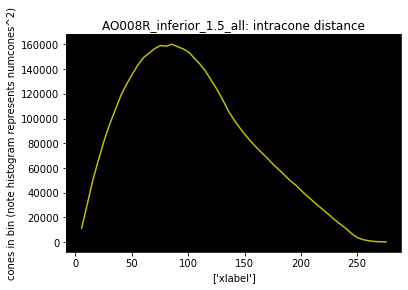

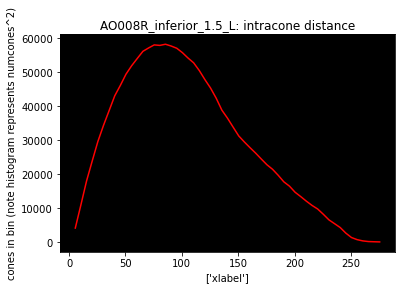

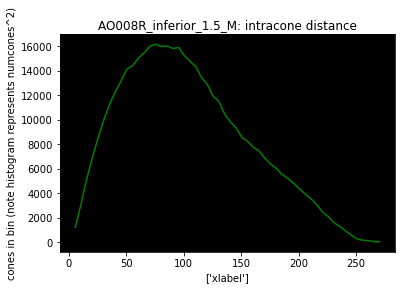

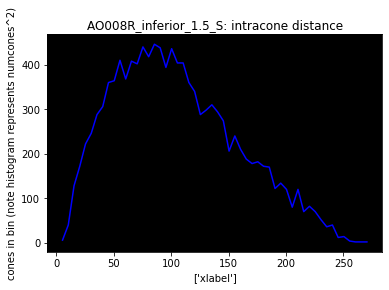

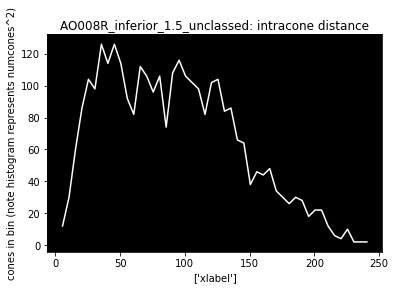

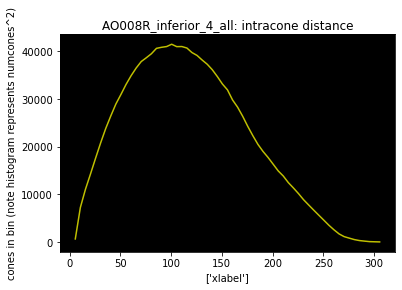

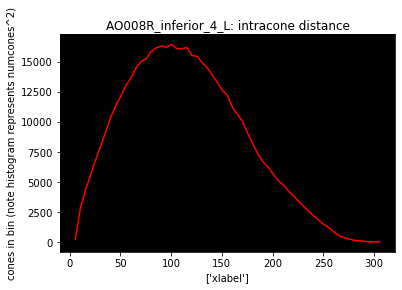

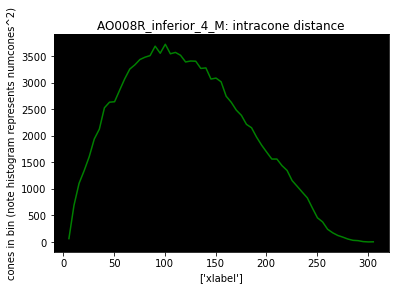

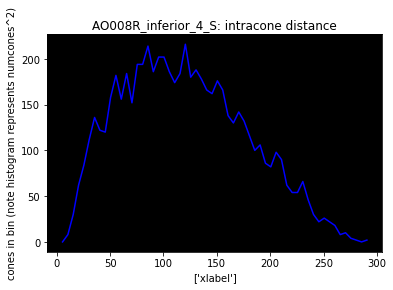

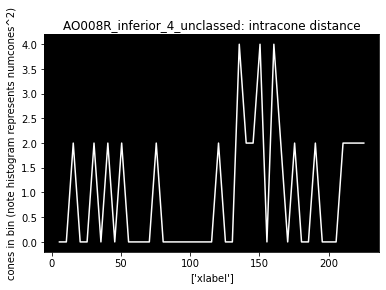

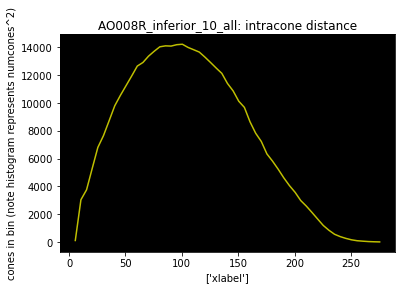

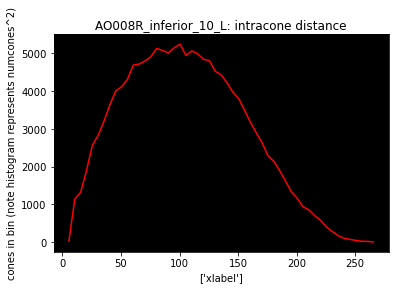

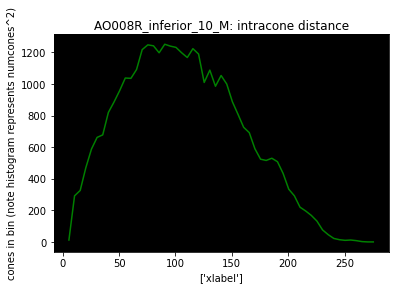

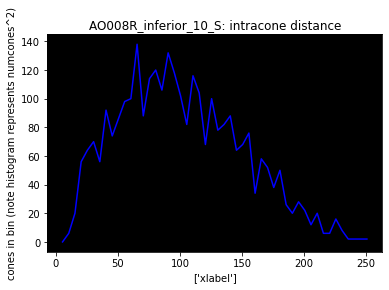

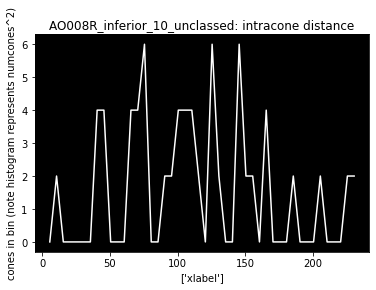

In [31]:
smp.viewIntraconeDistHists(save_name)

In [ ]:
file = h5py.File(save_path+'AO001R_inferior_1.5_all.hdf5','r')
print(file.keys())
print('')
print(file['meta'])
print(file['input_data'])
print("")
print(bytes(file['meta']['subject'][()]).decode("utf8"))
print(file['input_data']['cone_coord'][()])

In [ ]:
file.close()